In [1]:
#Its better to use EarlyStopping during Searching best model but I forget to do it. 
#When I fitted the best model than its trainning continues , previous learning is not reset 


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping


2026-01-19 17:35:37.120354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768844137.459778      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768844137.560157      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768844138.356184      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768844138.356240      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768844138.356244      17 computation_placer.cc:177] computation placer alr

In [2]:
import os
dataset_dir='/kaggle/input/melanoma-cancer-dataset'
train_dir=os.path.join(dataset_dir,'train')
test_dir=os.path.join(dataset_dir,'test')


In [3]:
train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.20,
    height_shift_range=0.20,
    shear_range=0.20,
    zoom_range=0.20,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1 / 255
)

test = ImageDataGenerator(
    rescale=1 / 255

)

train_data = train.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32
)

test_data = test.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

print("Classes labels", train_data.class_indices)

Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Classes labels {'Benign': 0, 'Malignant': 1}


In [4]:
import keras_tuner as kt


def build_model(hp):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    for i in range(hp.Int('layers_count', min_value=2, max_value=8)):
        kernels_count = hp.Int(f'kernel_count_{i}', min_value=40, max_value=100)
        model.add(Conv2D(kernels_count, kernel_size=(3, 3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(hp.Float('c1', min_value=0, max_value=0.70, step=0.1)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(hp.Float('c2', min_value=0, max_value=0.70, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=hp.Choice('optimizers', ['adam', 'sgd', 'rmsprop', 'adadelta']), loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


tuner_1 = kt.RandomSearch(build_model, objective='val_accuracy', max_trials=5)
tuner_1.search(train_data, validation_data=test_data, epochs=30,
               steps_per_epoch=train_data.samples // train_data.batch_size,
               validation_steps=test_data.samples // test_data.batch_size
                )


Trial 5 Complete [00h 00m 01s]

Best val_accuracy So Far: 0.9102822542190552
Total elapsed time: 06h 13m 40s


In [5]:
tuner_1.get_best_hyperparameters()[0].values

{'layers_count': 2,
 'kernel_count_0': 40,
 'kernel_count_1': 49,
 'c1': 0.0,
 'c2': 0.2,
 'optimizers': 'sgd',
 'kernel_count_2': 57,
 'kernel_count_3': 41,
 'kernel_count_4': 68,
 'kernel_count_5': 52}

In [6]:
model=tuner_1.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 40)   │        11,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 109, 109, 40)   │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 49)     │        17,689 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 52, 52, 49)     │           196 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 49)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 33124)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,960,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,122,086 (65.32 MB)

 Trainable params: 17,121,908 (65.31 MB)

 Non-trainable params: 178 (712.00 B)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',      
    patience=5,             
    restore_best_weights=True
)

model.fit(train_data,validation_data=test_data, epochs=80,
               steps_per_epoch=train_data.samples // train_data.batch_size,
               validation_steps=test_data.samples // test_data.batch_size,callbacks=[early_stop])

Epoch 1/80
371/371 ━━━━━━━━━━━━━━━━━━━━ 656s 2s/step - accuracy: 0.8748 - loss: 0.2894 - val_accuracy: 0.8936 - val_loss: 0.2707
Epoch 2/80
371/371 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - accuracy: 0.9062 - loss: 0.1986 - val_accuracy: 0.9068 - val_loss: 0.2560
Epoch 3/80
371/371 ━━━━━━━━━━━━━━━━━━━━ 654s 2s/step - accuracy: 0.8785 - loss: 0.2821 - val_accuracy: 0.6436 - val_loss: 0.6491
Epoch 4/80
371/371 ━━━━━━━━━━━━━━━━━━━━ 41s 107ms/step - accuracy: 0.9688 - loss: 0.1539 - val_accuracy: 0.7969 - val_loss: 0.4590
Epoch 5/80
371/371 ━━━━━━━━━━━━━━━━━━━━ 655s 2s/step - accuracy: 0.8776 - loss: 0.2799 - val_accuracy: 0.8695 - val_loss: 0.3001
Epoch 6/80
371/371 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - accuracy: 0.9062 - loss: 0.1952 - val_accuracy: 0.8821 - val_loss: 0.2808
Epoch 7/80
371/371 ━━━━━━━━━━━━━━━━━━━━ 652s 2s/step - accuracy: 0.8800 - loss: 0.2782 - val_accuracy: 0.8488 - val_loss: 0.3511


In [8]:
pred=model.predict(test_data,steps=test_data.samples // test_data.batch_size)
pred=(pred>0.5).astype('int32')
true=test_data.classes[:len(pred)]

62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 405ms/step


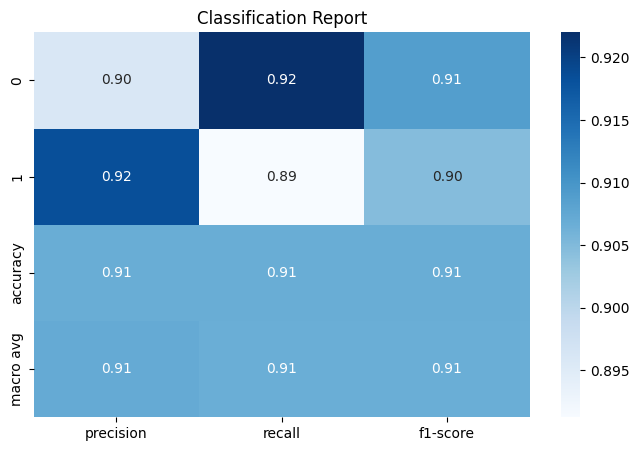

In [9]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cr = classification_report(true, pred, output_dict=True)
df = pd.DataFrame(cr).transpose()

plt.figure(figsize=(8,5))
sns.heatmap(df.iloc[:-1, :3], annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report")
plt.show()


In [10]:
model.save('final_model.keras')

In [11]:
from tensorflow.keras.models import load_model

model1 = load_model('/kaggle/input/final-model/keras/default/1/final_model.keras')
